# Import

In [260]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler as mms

import tensorflow
import keras
import tensorflow.keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, SimpleRNN

print(f"Numpy version : {np.__version__}")
print(f"Python Version: {sys.version}")
print(f"Tensor Flow Version: {tensorflow.__version__}")
print(f"Tensor Flow Keras Version: {tensorflow.keras.__version__}")
print(f"Keras Version: {keras.__version__}")

np.random.seed(1)
tensorflow.random.set_seed(5)

Numpy version : 1.20.3
Python Version: 3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]
Tensor Flow Version: 2.0.0
Tensor Flow Keras Version: 2.2.4-tf
Keras Version: 2.3.1


# Data import

In [261]:
base_data = pd.read_csv('petr4_treinamento.csv')
test_data = pd.read_csv('petr4_teste.csv')
base_data = base_data.dropna()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       20 non-null     object 
 1   Open       20 non-null     float64
 2   High       20 non-null     float64
 3   Low        20 non-null     float64
 4   Close      20 non-null     float64
 5   Adj Close  20 non-null     float64
 6   Volume     20 non-null     int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.2+ KB


In [262]:
base_data = base_data['Close']
base_data = base_data.values
base_data = base_data.reshape(-1, 1)
print(f'Base data: {type(base_data)}, {base_data.shape}')

test_data = test_data['Close']
test_data = test_data.values
test_data = test_data.reshape(-1, 1)
print(f'Test data: {type(test_data)}, {test_data.shape}')

Base data: <class 'numpy.ndarray'>, (1258, 1)
Test data: <class 'numpy.ndarray'>, (20, 1)


In [263]:
normalizer = mms(feature_range=(0,1))
train_data = normalizer.fit_transform(base_data)
print(train_data[0:5])

[[0.19275309]
 [0.16286889]
 [0.15240942]
 [0.16697797]
 [0.18789691]]


In [264]:
full_data = np.concatenate((base_data, test_data), axis=0)
print(f'Test data: {type(full_data)}, {full_data.shape}')

Test data: <class 'numpy.ndarray'>, (1278, 1)


# Funções

In [289]:
def build_model():
    model = Sequential([SimpleRNN(units=100, activation='tanh'), 
                        Dropout(0.3), 
                        Dense(units=50, activation='tanh'), 
                        Dropout(0.3), 
                        Dense(units=1, activation='linear')])

    model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

def build_modelLSTM():
    model = Sequential([LSTM(units=100, return_sequences=True),
                        Dropout(0.3),
                        LSTM(units=50, return_sequences=False),
                        Dropout(0.3),
                        Dense(1, activation='linear')])
    model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

def build_previsores(data, start):
    previsores = []
    preco_real = []

    for i in range(start, len(data)):
        previsores.append(data[i-start:i, :])
        preco_real.append(data[i, :1]) 
    
    previsores, preco_real = np.array(previsores), np.array(preco_real)
    #previsores = np.expand_dims(previsores, axis=2)

    return previsores, preco_real

def build_test_previsores(data, fdata, start):
    previsores = []
    inputs = full_data[len(fdata) - len(data) - start:]
    inputs = inputs.reshape(-1,data.shape[1])
    inputs = normalizer.transform(inputs)
    
    for j in range(start, len(inputs)):
        previsores.append(inputs[j-start:j,:])
    
    previsores = np.array(previsores)
    #previsores = np.expand_dims(previsores, axis=2)

    return previsores

def desvio_medio(predict, original):
    return (((original.mean() - predict.mean()) / original.mean()) * 100)

def plot_predict(previsores, preco_real):
    plt.plot(preco_real, color = 'red',  label = 'Preço Real')
    plt.plot(previsores, color = 'blue', label = 'Valor Previsto')
    plt.title('Previsor de Preços de Ações')
    plt.xlabel('Dia')
    plt.ylabel('Valor [R$]')
    plt.legend()
    plt.show()

def plot_resultadosfinais(parte1, parte2, parte3, preco_real):
    plt.plot(preco_real, 'r-', label = 'Preço real')
    plt.plot(parte1,     'g-', label = 'Parte 1')
    plt.plot(parte2,     'k-', label = 'Parte 2')
    plt.plot(parte3,     'b-', label = 'Parte 3')
    plt.title('Modelos SimpleRNN, LSTM (1 atrib.) e LSTM (2 atrib.)')
    plt.xlabel('Dia')
    plt.ylabel('Valor [R$]')
    plt.legend()
    plt.show()

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0 and epoch > 0: print('') #'\n'
        print('.', end='')

# Previsores

In [266]:
previsores = [[],[],[]]
test_previsores = [[],[],[]]
preco_real = [[],[],[]]

initial = 30
start = initial
for i in range(len(previsores)):
    previsores[i],  preco_real[i] = build_previsores(train_data,  start)  
    start += initial

start = initial
for i in range(len(test_previsores)):
    test_previsores[i] = build_test_previsores(test_data, full_data, start)
    start += initial

for i in range(len(previsores)):
    print(previsores[i].shape)
    print(test_previsores[i].shape)


(1228, 30, 1)
(20, 30, 1)
(1198, 60, 1)
(20, 60, 1)
(1168, 90, 1)
(20, 90, 1)


# Parte 1

### Neural Network

In [267]:
predictionlist = []

np.random.seed(1)
tensorflow.random.set_seed(5)

start = initial
for i in range(len(previsores)):
    print(f'Treinamento: {start} sequências, 100 ciclos')
    start+=initial

    model = build_model()
    model.fit(previsores[i], preco_real[i], epochs=100, batch_size=512, validation_split=0.3, verbose=0, callbacks=[PrintDot()])
    
    prediction = model.predict(test_previsores[i])

    prediction = normalizer.inverse_transform(prediction)
    predictionlist.append(prediction)

    print('\n')

    del prediction
    del model
    keras.backend.clear_session()


Treinamento: 30 sequências, 100 ciclos
....................................................................................................

Treinamento: 60 sequências, 100 ciclos
....................................................................................................

Treinamento: 90 sequências, 100 ciclos
....................................................................................................



### Resultados

In [268]:
start = initial
print(f'Média dos preços reais: R${test_data.mean(): .2f}')
for i in range(len(predictionlist)):
    print(f'Média das previsões com {start} dados anteriores: R${predictionlist[i].mean(): .2f}, Desvio médio: {desvio_medio(predictionlist[i],test_data): .4f}%')
    start+=initial

Média dos preços reais: R$ 29.15
Média das previsões com 30 dados anteriores: R$ 26.63, Desvio médio:  8.6566%
Média das previsões com 60 dados anteriores: R$ 27.96, Desvio médio:  4.0703%
Média das previsões com 90 dados anteriores: R$ 30.38, Desvio médio: -4.2083%


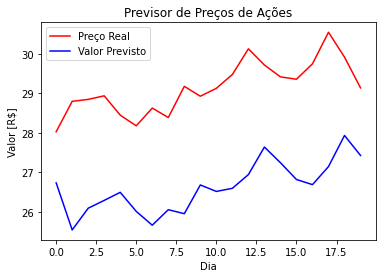

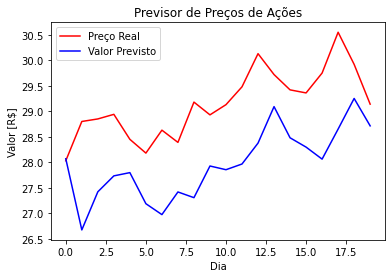

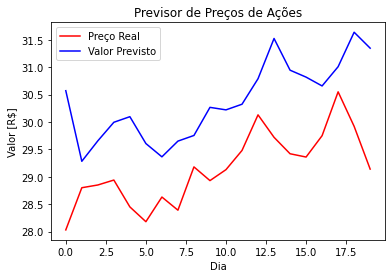

In [269]:
parte1 = []
for i in range(len(predictionlist)):
    plot_predict(predictionlist[i], test_data)
    parte1.append(predictionlist[i])

In [270]:
# Apesar da rede com menos dados sequenciais possuir um desvio médio maior que as outras, ela ainda acompanha a tendência de queda e subida dos dados reais graficamente. Portanto, 
# o tamanho de sequência pode não influenciar tanto neste caso, fazendo com que a escolha de menos dados sequenciais seja interessante, uma vez que é mais leve computacionalmente.

# Parte 2

### Neural Network LSTM

In [271]:
predictionlist = []

start = initial
for i in range(len(previsores)):
    print(f'Treinamento: {start} sequências, 100 ciclos')

    model = build_modelLSTM()
    model.fit(previsores[i], preco_real[i], epochs=100, batch_size=512, validation_split=0.3, verbose=0, callbacks=[PrintDot()])

    prediction = model.predict(test_previsores[i])
    prediction = normalizer.inverse_transform(prediction)
    predictionlist.append(prediction)

    print('\n')

    start+=initial

    del prediction
    del model
    keras.backend.clear_session()

Treinamento: 30 sequências, 100 ciclos
....................................................................................................

Treinamento: 60 sequências, 100 ciclos
....................................................................................................

Treinamento: 90 sequências, 100 ciclos
....................................................................................................



### Resultados Parte 2

In [272]:
start = initial
print(f'Média dos preços reais: R${test_data.mean(): .2f}')
for i in range(len(predictionlist)):
    print(f'Média das previsões com {start} dados anteriores: R${predictionlist[i].mean(): .2f}, Desvio médio: {desvio_medio(predictionlist[i], test_data): .4f}%')
    start+=initial

Média dos preços reais: R$ 29.15
Média das previsões com 30 dados anteriores: R$ 25.17, Desvio médio:  13.6365%
Média das previsões com 60 dados anteriores: R$ 25.36, Desvio médio:  13.0019%
Média das previsões com 90 dados anteriores: R$ 25.03, Desvio médio:  14.1228%


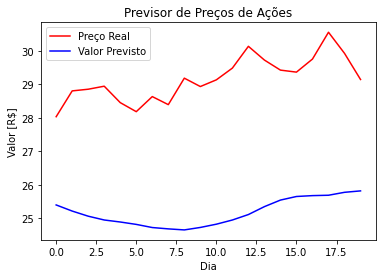

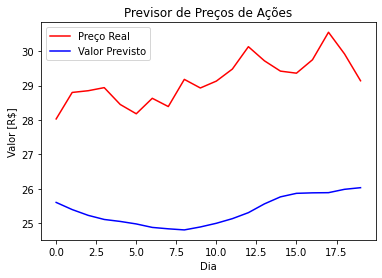

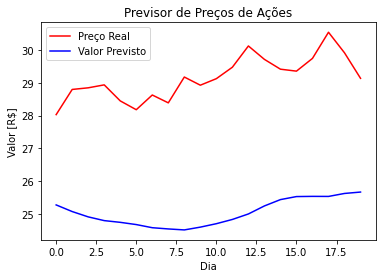

In [273]:
parte2 = []
for i in range(len(predictionlist)):
    plot_predict(predictionlist[i], test_data)
    parte2.append(predictionlist[i])

# Parte 3

### New Data import

In [274]:
base_data = pd.read_csv('petr4_treinamento.csv')
test_data = pd.read_csv('petr4_teste.csv')
base_data = base_data.dropna()

base_data = base_data.drop(['Open', 'High', 'Low', 'Adj Close'], 1)
base_data = base_data.iloc[:, 1:3].values

print(f'Base data: {type(base_data)}, {base_data.shape}')

test_data = test_data.drop(['Open', 'High', 'Low', 'Adj Close'], 1)
test_data = test_data.iloc[:, 1:3].values

print(f'Test data: {type(test_data)}, {test_data.shape}')

train_data = normalizer.fit_transform(base_data)
print(train_data[0:5])

full_data = np.concatenate((base_data, test_data), axis=0)
print(f'Full data: {type(full_data)}, {full_data.shape}')

Base data: <class 'numpy.ndarray'>, (1258, 2)
Test data: <class 'numpy.ndarray'>, (20, 2)
[[0.19275309 0.20620253]
 [0.16286889 0.32613739]
 [0.15240942 0.35250878]
 [0.16697797 0.35586938]
 [0.18789691 0.34661306]]
Full data: <class 'numpy.ndarray'>, (1278, 2)


C:\Users\felip\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """
C:\Users\felip\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # Remove the CWD from sys.path while we load stuff.


### Previsores Parte 3


In [275]:
previsores = [[],[],[]]
test_previsores = [[],[],[]]
preco_real = [[],[],[]]

start = initial
for i in range(len(previsores)):
    previsores[i],  preco_real[i]  = build_previsores(train_data, start)  
    start += initial

start = initial
for i in range(len(test_previsores)):
    test_previsores[i] = build_test_previsores(test_data, full_data, start)
    start += initial

for i in range(len(previsores)):
    print(previsores[i].shape)
    print(test_previsores[i].shape)

(1228, 30, 2)
(20, 30, 2)
(1198, 60, 2)
(20, 60, 2)
(1168, 90, 2)
(20, 90, 2)


### Neural Network LSTM

In [276]:
predictionlist = []

start = initial
for i in range(len(previsores)):
    print(f'Treinamento: {start} sequências, 100 ciclos')
    start+=initial

    model = build_modelLSTM()
    model.fit(previsores[i], preco_real[i], epochs=100, batch_size=512, validation_split=0.3, verbose=0, callbacks=[PrintDot()])

    prediction = model.predict(test_previsores[i])

    transf = np.zeros((20, 1))
    prediction = np.concatenate((prediction, transf), axis=1) #Eu fiz isso para conseguir concluir inverse_tranform, uma vez que o dado de teste foi formatado em (20, 2)
    prediction = normalizer.inverse_transform(prediction)
    prediction, transf = np.split(prediction, 2, axis=1)

    predictionlist.append(prediction)
    print('\n')

    del prediction
    del model
    keras.backend.clear_session()

Treinamento: 30 sequências, 100 ciclos
....................................................................................................(20, 1)


Treinamento: 60 sequências, 100 ciclos
....................................................................................................(20, 1)


Treinamento: 90 sequências, 100 ciclos
....................................................................................................(20, 1)




### Resultados

In [295]:
start = initial

print(f'Média dos preços reais: R${test_data[:, 0].mean(): .2f}')
for i in range(len(predictionlist)):
    print(f'Média das previsões com {start} dados anteriores: R${predictionlist[i].mean(): .2f}, Desvio médio: {desvio_medio(predictionlist[i], test_data[:, 0]): .4f}%')
    start+=initial

Média dos preços reais: R$ 29.15
Média das previsões com 30 dados anteriores: R$ 29.50, Desvio médio: -1.1927%
Média das previsões com 60 dados anteriores: R$ 29.16, Desvio médio: -0.0308%
Média das previsões com 90 dados anteriores: R$ 26.02, Desvio médio:  10.7503%


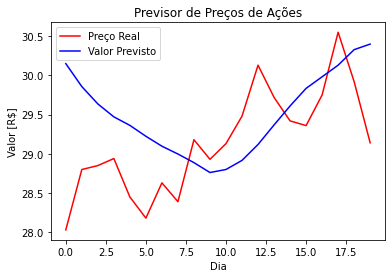

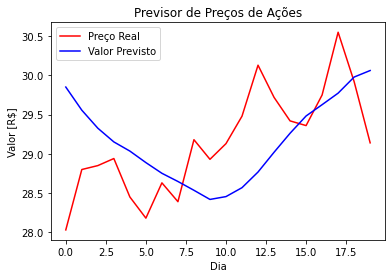

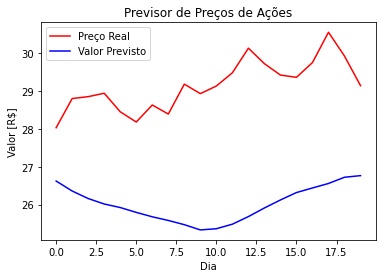

In [278]:
parte3 = []
for i in range(len(predictionlist)):
    plot_predict(predictionlist[i], test_data[:, 0])
    parte3.append(predictionlist[i])


# Resultados finais

30 Sequências


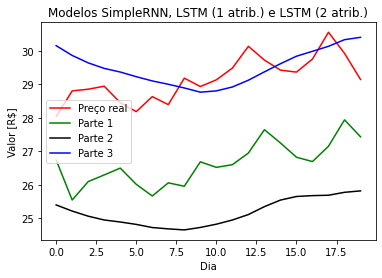

60 Sequências


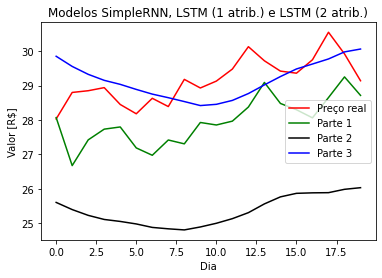

90 Sequências


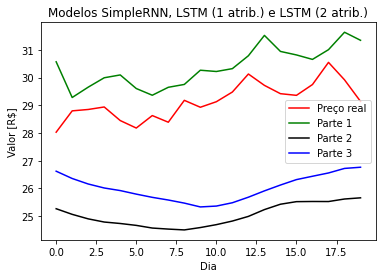

In [288]:
start = initial
for i in range(len(predictionlist)):
    print(f'{start} Sequências')
    plot_resultadosfinais(parte1[i], parte2[i], parte3[i], test_data[:, 0])
    start+=initial

# Considerações finais

Eu não entendi muito bem a proposta de prever sequências de 30, 60 e 90, enquanto se cria sequências de treinamento de 60, 120, 180. Tal ato contraria o 'input_shape' do modelo criado atualmente (LSTM) e impede o 'model.predict(previsores_teste[i])'. 


Segundo testes, a melhor forma de aprimorar a qualidade da rede seria diminuir o 'batch_size' do modelo. Fazendo isso, aumenta-se bastante o tempo de treinamento, mas a tendência da tangente é muito mais fluida.

Caso seja realmente necessário mudar as sequências de treinamento para 60, 120 e 180, ao alterar o initial para 60 na primeira ala de 'Previsores', todo o treinamento será direcionado para esta sequência.